# For audio info

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('output/data/df_audio.csv')
df

,file_path,sampling_rate,rms,dbfs,label,duration
0,./content/LibriSeVoc/gt/3857_180923_000008_000...,24000,0.061510,-24.220951,real,6.840000
1,./content/LibriSeVoc/gt/426_122821_000035_0000...,24000,0.060355,-24.385653,real,6.070000
2,./content/LibriSeVoc/gt/6081_41998_000029_0000...,24000,0.072021,-22.850687,real,11.680000
3,./content/LibriSeVoc/gt/5322_7680_000032_00000...,24000,0.034738,-29.183570,real,5.920000
4,./content/LibriSeVoc/gt/78_369_000026_000000.wav,24000,0.101507,-19.870003,real,9.849958
...,...,...,...,...,...,...
26397,./content/LibriSeVoc/diffwave/3879_173592_0000...,24000,0.068184,-23.326223,fake,7.232000
26398,./content/LibriSeVoc/diffwave/8095_274345_0000...,24000,0.060096,-24.422962,fake,11.370667
26399,./content/LibriSeVoc/diffwave/7794_295948_0000...,24000,0.072218,-22.826923,fake,17.290667
26400,./content/LibriSeVoc/diffwave/6209_34599_00000...,24000,0.079749,-21.965374,fake,6.304000


In [3]:
df.label.value_counts()

label
real    13201
fake    13201
Name: count, dtype: int64

In [4]:
len(df.duration.unique())

5125

In [5]:
df.duration.value_counts()

duration
5.920000     59
5.280000     57
5.130667     55
5.930667     54
6.880000     52
             ..
11.550083     1
22.340000     1
15.300083     1
12.099958     1
17.290667     1
Name: count, Length: 5125, dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26402 entries, 0 to 26401
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file_path      26402 non-null  object 
 1   sampling_rate  26402 non-null  int64  
 2   rms            26402 non-null  float64
 3   dbfs           26402 non-null  float64
 4   label          26402 non-null  object 
 5   duration       26402 non-null  float64
dtypes: float64(3), int64(1), object(2)
memory usage: 1.2+ MB


In [7]:
df.describe()

,sampling_rate,rms,dbfs,duration
count,26402.0,26402.000000,26402.000000,26402.000000
mean,24000.0,0.060800,-24.741539,9.526883
std,0.0,0.018722,2.791288,4.186767
min,24000.0,0.009805,-40.170113,5.000000
25%,24000.0,0.049083,-26.181149,6.410667
50%,24000.0,0.060280,-24.396368,8.270042
75%,24000.0,0.070954,-22.980284,11.370667
max,24000.0,0.228224,-12.832742,33.258667


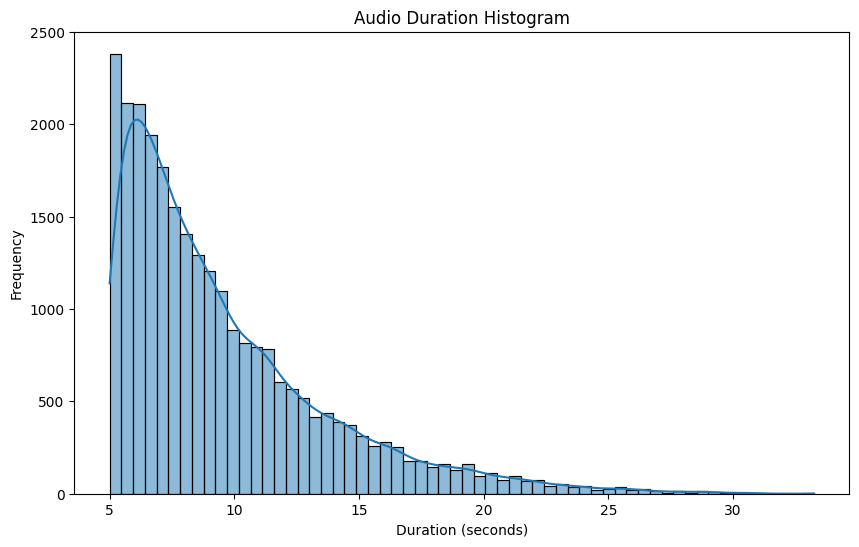

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=60, kde=True)
plt.title('Audio Duration Histogram')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [9]:
df = df[df['duration'] <= 10]
df

,file_path,sampling_rate,rms,dbfs,label,duration
0,./content/LibriSeVoc/gt/3857_180923_000008_000...,24000,0.061510,-24.220951,real,6.840000
1,./content/LibriSeVoc/gt/426_122821_000035_0000...,24000,0.060355,-24.385653,real,6.070000
3,./content/LibriSeVoc/gt/5322_7680_000032_00000...,24000,0.034738,-29.183570,real,5.920000
4,./content/LibriSeVoc/gt/78_369_000026_000000.wav,24000,0.101507,-19.870003,real,9.849958
5,./content/LibriSeVoc/gt/39_121915_000013_00000...,24000,0.027996,-31.057756,real,5.529958
...,...,...,...,...,...,...
26394,./content/LibriSeVoc/diffwave/7447_91186_00002...,24000,0.057005,-24.881546,fake,9.034667
26395,./content/LibriSeVoc/diffwave/6367_65536_00003...,24000,0.073831,-22.635100,fake,7.136000
26397,./content/LibriSeVoc/diffwave/3879_173592_0000...,24000,0.068184,-23.326223,fake,7.232000
26400,./content/LibriSeVoc/diffwave/6209_34599_00000...,24000,0.079749,-21.965374,fake,6.304000


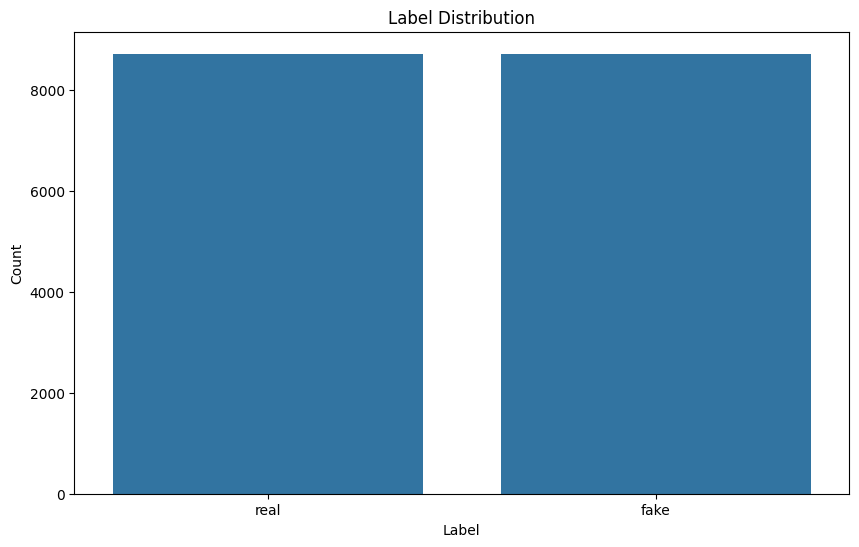

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# For features file

In [11]:
df_features = pd.read_csv('./output/data/features.csv')

In [12]:
features = df_features.drop(columns=['label', 'file_path', 'sampling_rate', 'mfcc_3_mean', 'mfcc_24_mean', 'mfcc_25_mean', 'mfcc_26_mean',
                                     'mfcc_27_mean', 'mfcc_28_mean', 'mfcc_29_mean', 'mfcc_30_mean'], axis=1).copy()
labels = df_features['label']

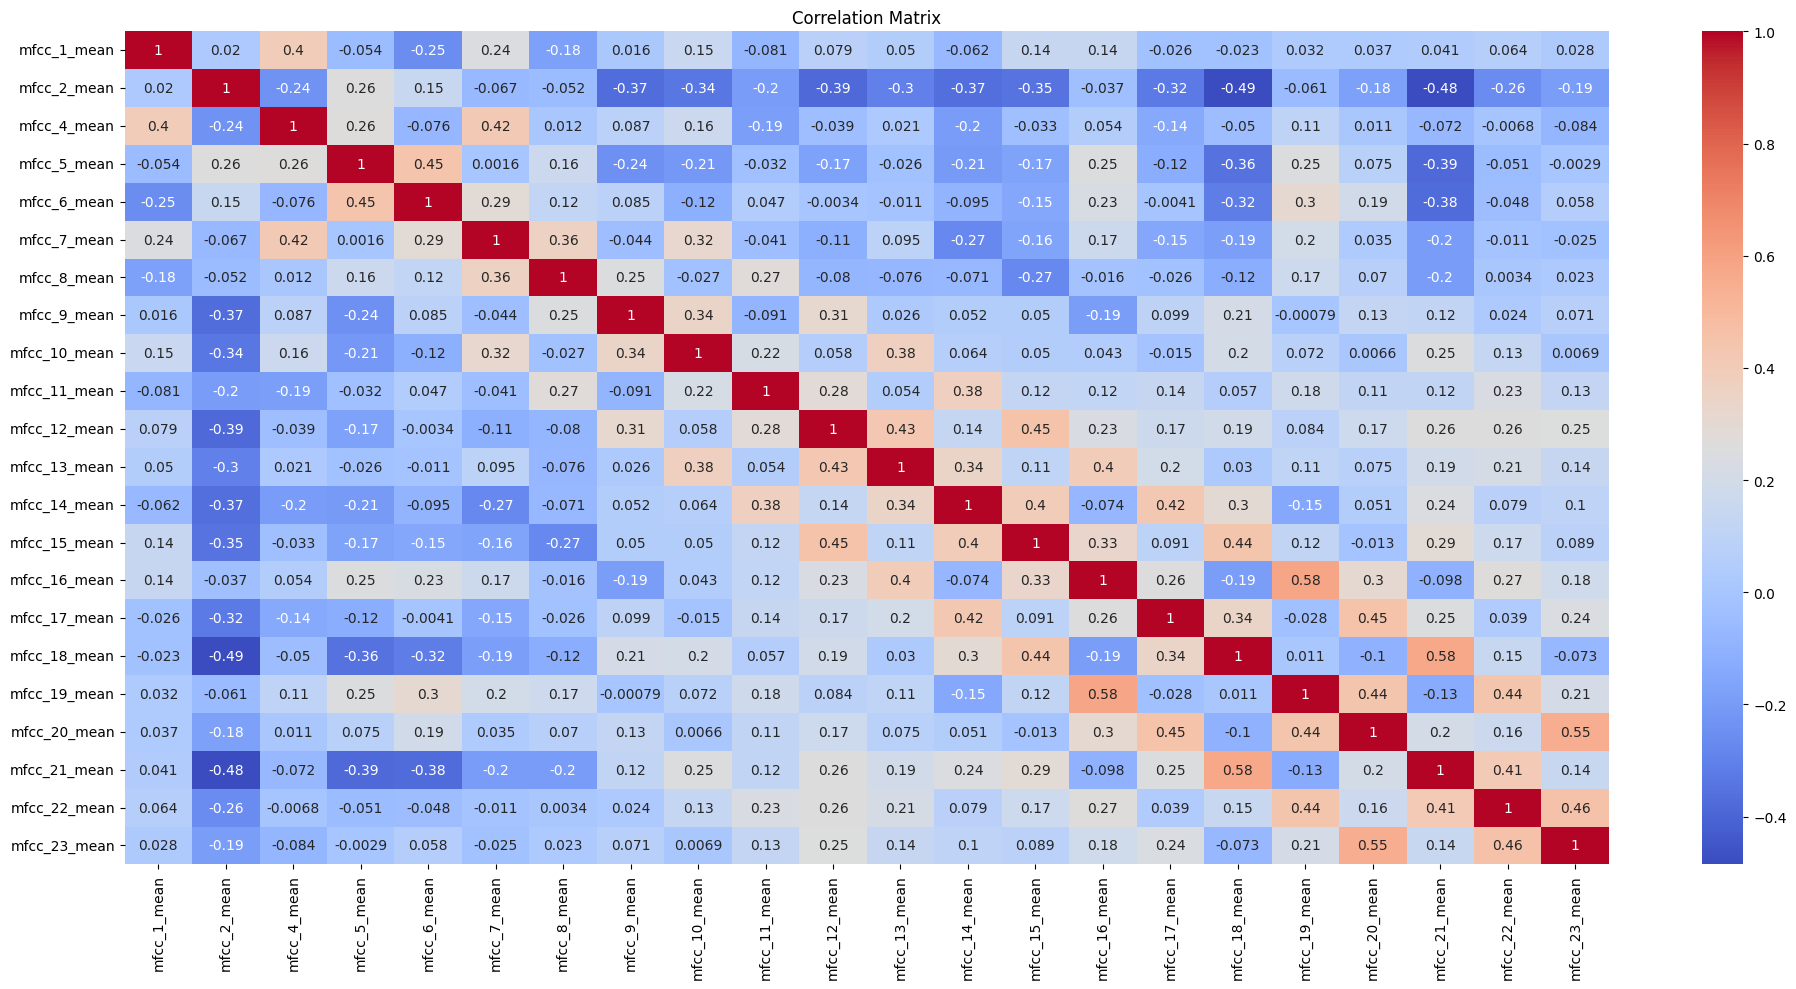

In [13]:
correlation_matrix = features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Merging

In [14]:
merged_df = pd.merge(df, df_features.drop(columns=['sampling_rate', 'label']), on='file_path')
merged_df.describe()

,sampling_rate,rms,dbfs,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
count,17423.0,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,...,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000,17423.000000
mean,24000.0,0.061057,-24.721248,7.109606,-317.399008,128.426316,-42.811505,7.844666,1.689817,-29.685066,...,-7.120366,-6.935915,-5.877287,-4.549254,-4.390541,-3.814031,-2.561450,-1.702591,-1.516864,-1.086812
std,0.0,0.019329,2.834867,1.395377,28.898364,16.979044,20.744314,11.595239,8.749681,8.300534,...,2.776710,2.456679,2.423796,2.675777,2.607725,2.533253,2.786368,2.813710,2.694409,3.035676
min,24000.0,0.010383,-39.672676,5.000000,-427.511202,41.619881,-115.047345,-36.143074,-38.206965,-58.228549,...,-19.358950,-16.845920,-14.200669,-14.582482,-16.450676,-13.262357,-10.828415,-14.292117,-13.600392,-11.172944
25%,24000.0,0.048934,-26.207538,5.920000,-337.322217,117.982159,-55.635086,0.364516,-3.562770,-34.912842,...,-9.053816,-8.540291,-7.411154,-6.365587,-6.053100,-5.479578,-4.501600,-3.600940,-3.272380,-3.172028
50%,24000.0,0.060369,-24.383595,6.920042,-317.991503,129.146136,-41.338804,7.757048,1.827502,-29.694026,...,-7.189279,-7.053420,-5.881905,-4.765975,-4.555928,-4.030820,-2.979127,-1.982677,-1.963911,-1.624060
75%,24000.0,0.071295,-22.938708,8.224000,-297.521476,139.841606,-29.200435,15.176493,7.084670,-24.583285,...,-5.390611,-5.491033,-4.404384,-3.009174,-2.884144,-2.378965,-0.981034,-0.103758,-0.091980,0.526170
max,24000.0,0.228224,-12.832742,10.000000,-220.653721,188.442505,28.522664,54.115866,40.257805,1.001002,...,8.061415,4.827159,6.715911,9.101637,9.975339,9.202112,13.579963,12.672208,12.967291,14.676288


In [15]:
merged_df.columns

Index(['file_path', 'sampling_rate', 'rms', 'dbfs', 'label', 'duration',
       'mfcc_1_mean', 'mfcc_2_mean', 'mfcc_3_mean', 'mfcc_4_mean',
       'mfcc_5_mean', 'mfcc_6_mean', 'mfcc_7_mean', 'mfcc_8_mean',
       'mfcc_9_mean', 'mfcc_10_mean', 'mfcc_11_mean', 'mfcc_12_mean',
       'mfcc_13_mean', 'mfcc_14_mean', 'mfcc_15_mean', 'mfcc_16_mean',
       'mfcc_17_mean', 'mfcc_18_mean', 'mfcc_19_mean', 'mfcc_20_mean',
       'mfcc_21_mean', 'mfcc_22_mean', 'mfcc_23_mean', 'mfcc_24_mean',
       'mfcc_25_mean', 'mfcc_26_mean', 'mfcc_27_mean', 'mfcc_28_mean',
       'mfcc_29_mean', 'mfcc_30_mean'],
      dtype='object')

In [16]:
merged_df.head()

,file_path,sampling_rate,rms,dbfs,label,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
0,./content/LibriSeVoc/gt/3857_180923_000008_000...,24000,0.061510,-24.220951,real,6.840000,-304.341270,113.709097,-44.021291,28.256102,...,-7.879508,-11.564848,-7.241586,-3.500644,-8.572959,-7.769196,-6.200805,-9.601032,-1.045484,1.696635
1,./content/LibriSeVoc/gt/426_122821_000035_0000...,24000,0.060355,-24.385653,real,6.070000,-288.430056,156.781227,-42.138849,21.731352,...,-10.782125,-11.156759,-9.278637,-7.561083,-6.570046,-6.295412,-5.074236,-3.588240,-3.976979,-4.318006
2,./content/LibriSeVoc/gt/5322_7680_000032_00000...,24000,0.034738,-29.183570,real,5.920000,-313.729559,133.650065,-45.776206,-0.649869,...,-7.809381,-3.840896,-4.639575,-5.083332,-2.645830,-3.523515,-4.064678,-1.823462,-1.784046,-3.711713
3,./content/LibriSeVoc/gt/78_369_000026_000000.wav,24000,0.101507,-19.870003,real,9.849958,-338.528304,110.269715,-26.445261,7.784086,...,-6.991639,-4.952648,-4.918112,-5.376414,-5.329774,-4.305240,-3.679742,-3.917728,-2.481780,-1.619357
4,./content/LibriSeVoc/gt/39_121915_000013_00000...,24000,0.027996,-31.057756,real,5.529958,-288.435487,117.139206,-53.460400,14.722782,...,-8.898185,-8.144262,-5.093298,0.412901,0.513141,1.108503,1.737505,-0.865436,0.617007,0.743553


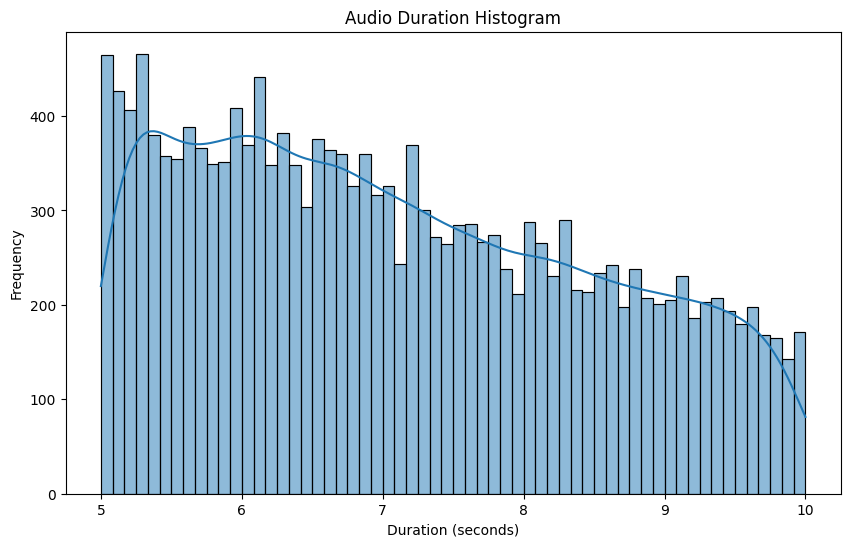

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['duration'], bins=60, kde=True)
plt.title('Audio Duration Histogram')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [18]:
merged_df.drop(columns=['rms', 'dbfs', 'sampling_rate'], inplace=True)

In [19]:
merged_df.to_csv('./output/data/merged_df.csv', index=False)

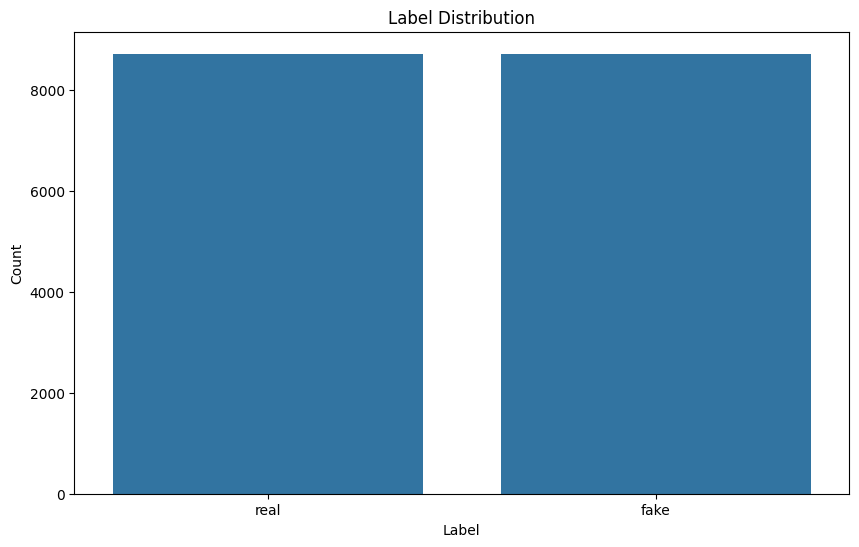

In [20]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=merged_df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

# For ASVSpoof2021

In [21]:
df = pd.read_csv('output/data/df_audio_ASV.csv')
df

,file_path,label,duration
0,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,3.96800
1,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,1.72800
2,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,2.68800
3,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,1.14875
4,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,3.25600
...,...,...,...
11065,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,1.47200
11066,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,3.44000
11067,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,1.19950
11068,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,3.58400


In [22]:
df.label.value_counts()

label
real    5535
fake    5535
Name: count, dtype: int64

In [23]:
len(df.duration.unique())

3413

In [24]:
df.duration.value_counts()

duration
2.752000    143
2.624000    126
3.520000    122
2.944000    121
2.880000    118
           ... 
2.221312      1
3.542813      1
1.804563      1
2.311437      1
1.199500      1
Name: count, Length: 3413, dtype: int64

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11070 entries, 0 to 11069
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_path  11070 non-null  object 
 1   label      11070 non-null  object 
 2   duration   11070 non-null  float64
dtypes: float64(1), object(2)
memory usage: 259.6+ KB


In [26]:
df.describe()

,duration
count,11070.000000
mean,3.140876
std,1.273930
min,0.400000
25%,2.220344
50%,2.981594
75%,3.928000
max,13.440000


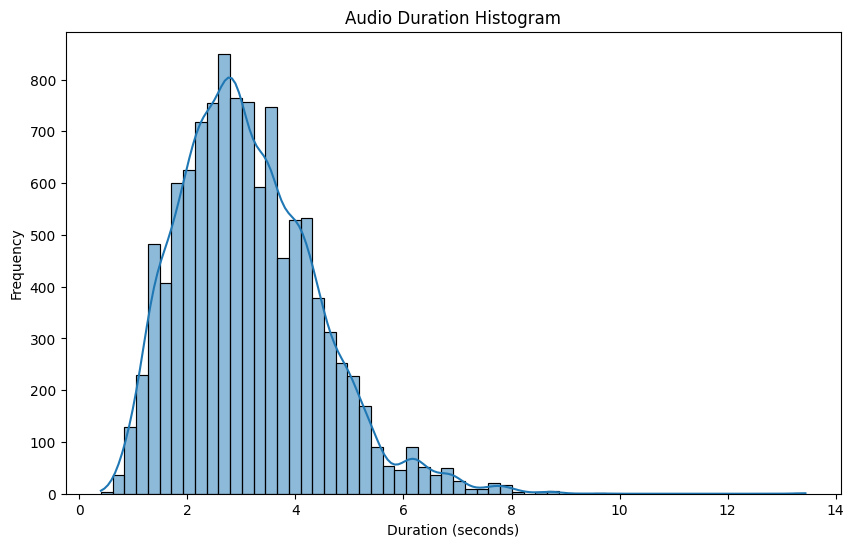

In [27]:
plt.figure(figsize=(10, 6))
sns.histplot(df['duration'], bins=60, kde=True)
plt.title('Audio Duration Histogram')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()

In [28]:
df = df[df['duration'] <= 10]
df

,file_path,label,duration
0,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,3.96800
1,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,1.72800
2,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,2.68800
3,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,1.14875
4,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,3.25600
...,...,...,...
11065,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,1.47200
11066,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,3.44000
11067,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,1.19950
11068,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,3.58400


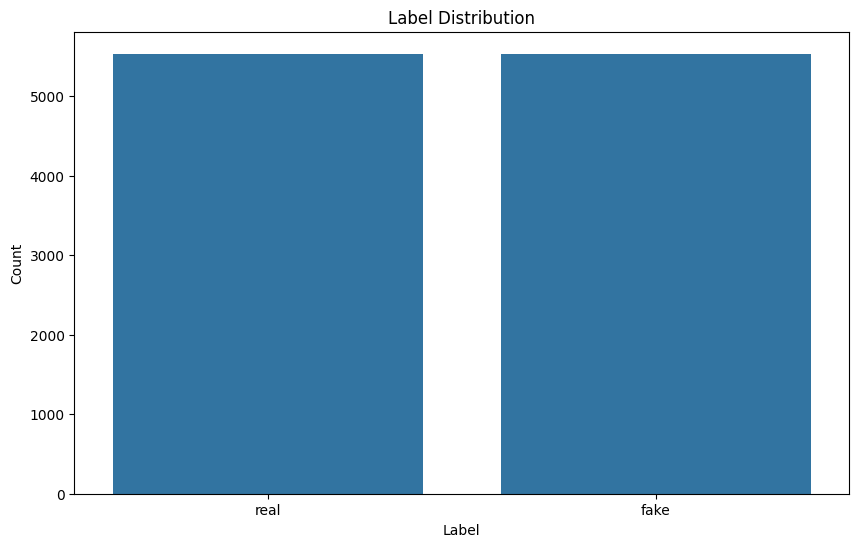

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x='label', data=df)
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [30]:
df_features = pd.read_csv('./output/data/features_ASV.csv')

In [31]:
features = df_features.drop(columns=['label', 'file_path', 'sampling_rate', 'mfcc_3_mean', 'mfcc_24_mean', 'mfcc_25_mean', 'mfcc_26_mean',
                                     'mfcc_27_mean', 'mfcc_28_mean', 'mfcc_29_mean', 'mfcc_30_mean'], axis=1).copy()
labels = df_features['label']

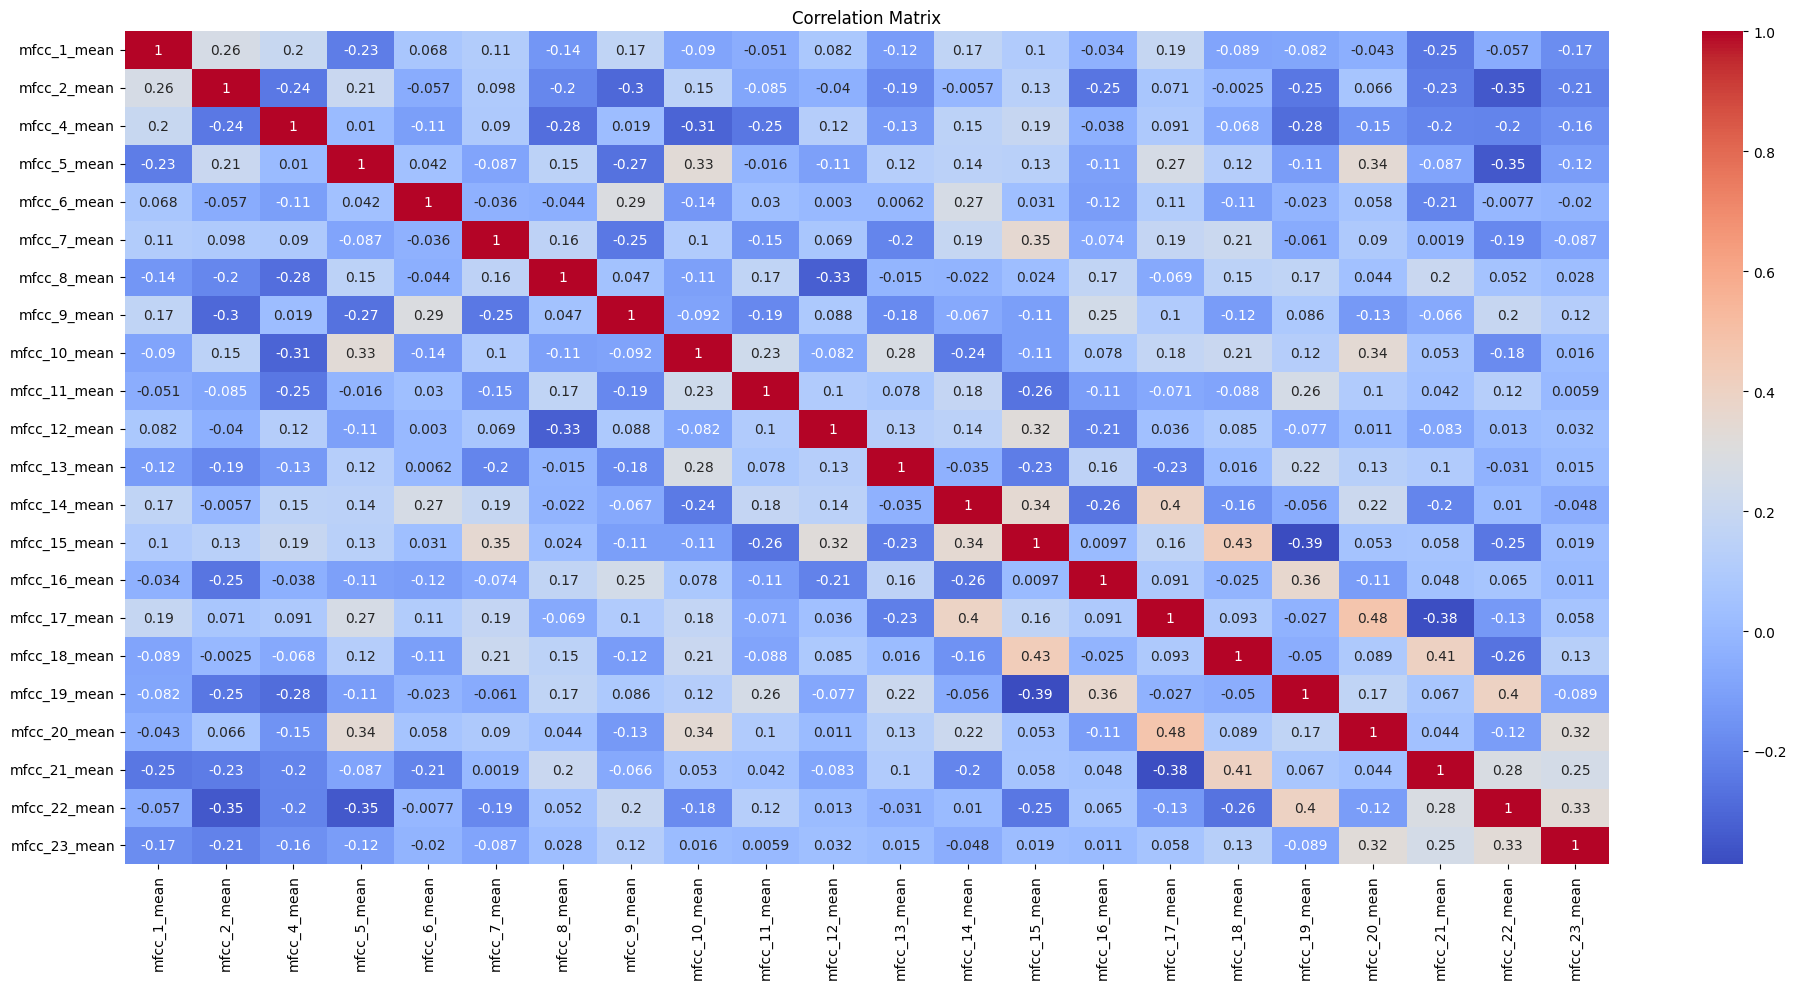

In [32]:
correlation_matrix = features.corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot = True)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Merging

In [33]:
merged_df = pd.merge(df, df_features.drop(columns=['sampling_rate', 'label']), on='file_path')

In [34]:
merged_df

,file_path,label,duration,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,...,mfcc_21_mean,mfcc_22_mean,mfcc_23_mean,mfcc_24_mean,mfcc_25_mean,mfcc_26_mean,mfcc_27_mean,mfcc_28_mean,mfcc_29_mean,mfcc_30_mean
0,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,3.96800,-274.839344,113.385251,-55.019757,25.615045,-13.574152,-14.692320,-20.124984,...,-4.893089,-9.735389,-4.160935,-5.389757,-7.897711,-2.541400,-1.229260,-1.323287,-4.511141,-2.129996
1,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,1.72800,-270.448701,122.997073,-53.514227,54.746670,-23.068803,-36.842570,-30.808156,...,-8.979152,-9.425405,-6.582604,-1.044999,0.019754,-5.429664,-4.251259,-0.538843,-2.470203,-2.564595
2,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,2.68800,-277.021509,161.223848,-31.419274,13.304288,-17.356467,-24.646507,-18.134337,...,-4.326402,-11.344032,-6.189545,-1.234809,-7.808018,-7.244382,-3.928664,-1.700875,-1.184348,-5.402412
3,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,1.14875,-251.493767,109.608147,-74.580828,31.521998,-35.268413,-35.786502,-24.115362,...,-1.832084,-0.672888,-2.994926,-2.673198,2.279632,11.384725,16.515837,17.653809,11.689546,3.771389
4,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,real,3.25600,-226.498432,130.271562,-72.013331,48.188397,-15.057686,-30.444950,-32.805923,...,-13.152443,-5.562284,-7.884548,-6.297796,-3.962418,-3.252032,-5.221850,-6.735967,0.083158,2.052527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11063,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,1.47200,-221.387198,134.859480,-54.475937,31.517550,-18.432171,-4.586316,-20.243840,...,-6.731990,-9.740725,-4.614656,-6.792969,-8.260633,-4.768609,-5.994986,-4.385023,-5.664790,-3.965585
11064,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,3.44000,-200.673092,155.100745,-68.914149,14.314836,-21.250184,-15.064963,-24.458378,...,-10.189279,-9.760100,-8.609093,-8.945636,-6.111569,-5.954047,-3.510326,-4.244118,-4.565288,-1.851681
11065,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,1.19950,-249.391770,128.301859,-86.249748,7.712204,-52.857591,-22.976306,-26.479922,...,-0.974288,-2.382537,7.423975,11.747133,8.508309,7.055831,3.802842,0.249871,-0.637041,2.258549
11066,./content/ASVspoof2021/ASVspoof2021_DF_eval/fl...,fake,3.58400,-229.160561,117.199627,-65.641832,44.284898,-17.235047,-25.301386,-25.549237,...,-4.002469,-10.728698,-11.249189,-7.759867,-6.375366,-3.175890,-4.068972,-4.223631,-1.712918,-3.034780


In [35]:
merged_df.to_csv('./output/data/merged_df.csv', mode='a', header=False, index=False)

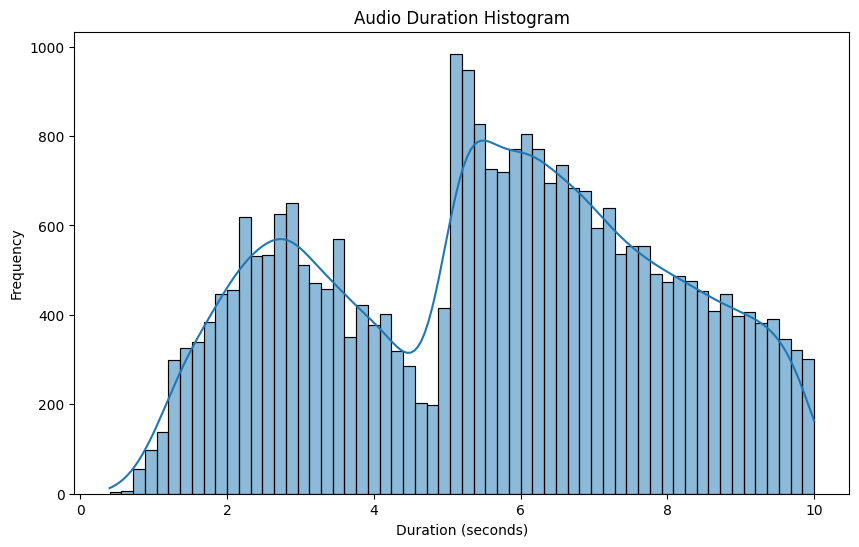

In [36]:
merged_df = pd.read_csv('./output/data/merged_df.csv')

plt.figure(figsize=(10, 6))
sns.histplot(merged_df['duration'], bins=60, kde=True)
plt.title('Audio Duration Histogram')
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.show()